In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

california_dataset = fetch_california_housing()
x_train, x_test, y_train, y_test = train_test_split(california_dataset.data, california_dataset.target, test_size=0.2, random_state=42)

In [7]:
import torch
from tqdm import tqdm

class LinearRegressionGradientDescent:
    def __init__(self, x, y, learning_rate: float, device: torch.device):
        self.x = x.to(device)
        self.y = y.to(device)
        self.learning_rate = learning_rate

        assert x.shape[0] == y.shape[0], "The number of samples in x_train and y_train must be equal"

        self.num_samples = y.shape[0]
        self.num_features = x.shape[1]

        self.bias = torch.zeros((1, 1)).to(device)
        self.weights = torch.zeros((self.num_features, 1)).to(device)

    def predict(self, bias, weights, x):
        return torch.matmul(x, weights) + bias

    def loss(self, y, predicted):
        # MSE loss
        return torch.mean(torch.square(y - predicted))
    
    def step(self):
        # Make predictions using the current weights and bias
        predicted = self.predict(self.bias, self.weights, self.x)
        # Get the loss 
        loss = self.loss(self.y, predicted)
        # Calculate the gradients
        delta_weights = 1 / self.num_samples * torch.matmul(self.x.T, (predicted - self.y.reshape(-1, 1)))
        delta_bias = 1 / self.num_samples * torch.sum(predicted - self.y.reshape(-1, 1))
        # Update the weights and bias
        self.weights = self.weights - self.learning_rate * delta_weights
        self.bias = self.bias - self.learning_rate * delta_bias
        return loss

Running on cuda


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training: 100%|██████████| 1000/1000 [00:14<00:00, 68.02it/s]


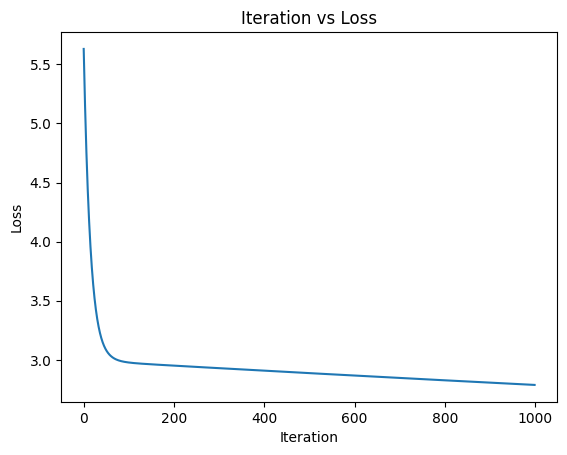

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Select the device to run the code on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print (f'Running on {device}')

iterations = 1000
learning_rate = 10e-9
model = LinearRegressionGradientDescent(torch.Tensor(x_train), torch.Tensor(y_train), learning_rate, device)
training_history = {}

for iteration in tqdm(range(iterations), desc="Training"):
    loss = model.step()
    
    loss_value = loss.cpu().numpy().item()
    bias = model.bias.cpu().detach()
    weights = model.weights.cpu().detach()
    training_history[iteration] = (loss_value, bias, weights)

plt.xlabel("Iteration")
plt.title("Iteration vs Loss")
plt.ylabel("Loss")
plt.plot(np.arange(iterations), [training_history[i][0] for i in range(iterations)])

In [45]:
# Plot the results
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

def plot_predictions(iteration_index, random_indices, var_index, x_test, y_test, weights, bias) -> None:
    x_test = x_test[random_indices]
    y_test = y_test[random_indices]
    y_predicted = (torch.matmul(x_test, weights) + bias).flatten()

    # Calculate the MSE
    mse = torch.mean(torch.square(y_test - y_predicted))

    # Clean everything
    plt.clf()
    plt.xlabel(california_dataset.feature_names[var_index])
    plt.ylabel(california_dataset.target_names[0])
    plt.scatter(x_test[:,var_index].cpu().numpy(), y_test.cpu().numpy()) # Plot test data
    plt.scatter(x_test[:,var_index].cpu().numpy(), y_predicted.cpu().numpy(), color="k") # Plot predictions
    plt.title(f"Iteration {iteration_index} - MSE: {mse:.2f}")

def animate(frame_index: int) -> None:
    iteration_index = iterations_schedule[frame_index]
    _, bias, weights = training_history[iteration_index]
    plot_predictions(iteration_index, random_indices, variable_index, x_test, y_test, weights, bias)

# Data to plot
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

num_points_to_display = 100
variable_index = 3

num_iterations_to_display = 100
# Generate a linear schedule for the iterations to display
iterations_schedule = np.linspace(0, iterations - 1, num_iterations_to_display, dtype=np.int32)

# Select random indices to display over time
random_indices = np.random.choice(x_test.shape[0], num_points_to_display)

fig = plt.figure()
anim = FuncAnimation(fig, animate, init_func=None, frames=num_iterations_to_display, interval=500, blit=False)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()